# Whatpulse Keypress Counter

By Kenneth Burchfiel

Released under the MIT license

This program reads Whatpulse keypress data (stored in local SQLite databases); combines that data into a single Pandas DataFrame; and then performs analyses on that data.

More documentation/explanation of the code will be provided in the future.

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
current_computer_nickname = 'ga15pyd' # Used for naming .csv files

database_paths_list = ['C:\\Users\\kburc\\AppData\\Local\\whatpulse\\whatpulse.db', 'C:\\Users\\kburc\\D1V1\\Documents\\whatpulse_database_backups\\a13r2_whatpulse.db'] # Necessary to escape the backslashes

In [3]:
def analyze_keypresses(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True)    
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [4]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(analyze_keypresses(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 4793402
Maximum keypresses in one day with this computer: 73788
Average daily keypresses (at least for days with 1 or more keypresses): 29228.060975609755

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
434


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2021-12-03,14409
2021-12-04,3196
2021-12-05,11364


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses).

In [5]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'

In [6]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['30_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(30).mean()
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses

443


,keypresses,7_day_ma,30_day_ma,365_day_ma
Date,,,,
2020-09-21,19081,NaN,NaN,NaN
2020-09-22,32771,NaN,NaN,NaN
2020-09-23,32065,NaN,NaN,NaN
2020-09-24,34698,NaN,NaN,NaN
2020-09-25,47038,NaN,NaN,NaN
...,...,...,...,...
2021-12-03,14409,30281.428571,28219.700000,28847.654795
2021-12-04,3196,30364.428571,27019.600000,28782.041096
2021-12-05,11364,26104.285714,26510.200000,28714.983562


In [7]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,keypresses,7_day_ma,30_day_ma,365_day_ma
Date,,,,
2021-11-28,41185,19629.571429,24624.500000,29010.821918
2021-11-29,38798,17992.285714,25576.466667,29024.145205
2021-11-30,36822,17395.428571,26570.500000,28940.005479
2021-12-01,29954,21674.571429,27443.366667,28964.024658
2021-12-02,48187,28558.428571,29049.600000,28976.498630
2021-12-03,14409,30281.428571,28219.700000,28847.654795
2021-12-04,3196,30364.428571,27019.600000,28782.041096
2021-12-05,11364,26104.285714,26510.200000,28714.983562
2021-12-06,58253,28883.571429,27479.533333,28866.978082


THe following cell calculates my top 50 one-day keypress totals.

In [28]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index()
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,30_day_ma,365_day_ma
0,1,2021-02-22,77753,47983.000000,41921.733333,NaN
1,2,2020-11-23,76313,50377.571429,38630.666667,NaN
2,3,2020-11-19,75444,47285.571429,38100.900000,NaN
3,4,2021-11-09,73788,37843.285714,32561.166667,29584.802740
4,5,2021-02-08,70591,30177.428571,34684.800000,NaN
5,6,2021-04-06,68313,40455.857143,41385.233333,NaN
6,7,2021-02-15,67930,46174.571429,38828.533333,NaN
7,8,2020-11-30,67533,20747.428571,35387.133333,NaN
8,9,2021-02-17,67505,45946.571429,40793.766667,NaN
9,10,2021-10-12,66517,39971.285714,37342.833333,29886.202740


In [8]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,30_day_ma,365_day_ma
count,443.000000,437.000000,414.000000,79.000000
mean,29994.033860,30039.289964,29958.920290,29551.233362
std,18403.450098,9698.792633,6489.454460,376.729727
min,0.000000,4266.142857,18423.300000,28714.983562
25%,15482.500000,23691.285714,23569.008333,29341.504110
50%,29135.000000,30582.285714,30286.883333,29658.849315
75%,43543.500000,37266.857143,35834.050000,29862.645205
max,77753.000000,50377.571429,41971.566667,30033.476712


In [9]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      443.000000
mean     29994.033860
std      18403.450098
min          0.000000
50%      29135.000000
90%      54602.200000
91%      55256.820000
92%      56413.680000
93%      57430.500000
94%      58913.280000
95%      60696.900000
96%      62130.280000
97%      64895.200000
98%      66675.080000
99%      69634.240000
100%     77753.000000
max      77753.000000
Name: keypresses, dtype: float64

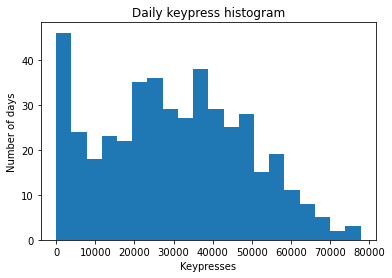

In [10]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 20)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [11]:
print("Total keypresess since", str(df_combined_daily_keypresses.index[0])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 13,287,357


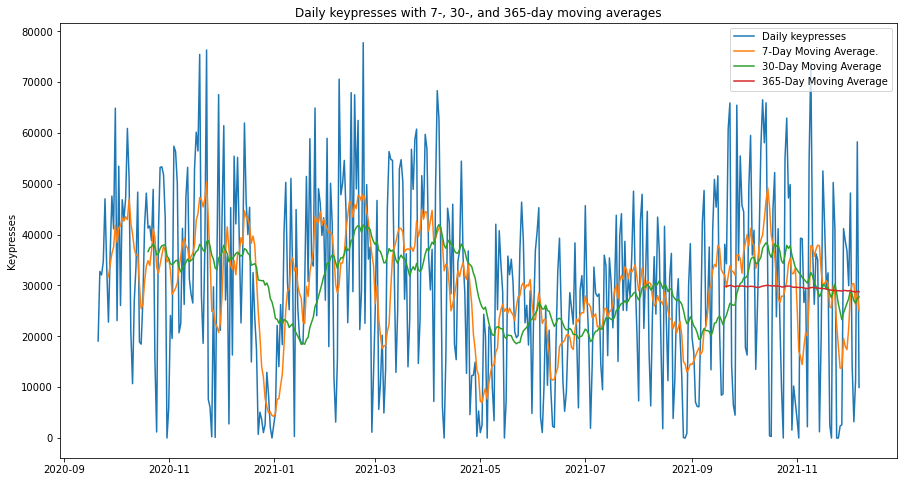

In [12]:
fig, axes = plt.subplots(figsize=[15,8])
fig.set_facecolor('white')

axes.plot(df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
axes.plot(df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average.')
axes.plot(df_combined_daily_keypresses['30_day_ma'],label='30-Day Moving Average')
axes.plot(df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend()
plt.title('Daily keypresses with 7-, 30-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

List of tables in each WhatPulse database file:

In [13]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [14]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

In [15]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Tue Dec  7 02:26:38 2021 (local time)
Total run time: 6.26 second(s) (0.0 minute(s) and 6.26 second(s))
